# バスケットボールコンペ

多分以下シーズン1<br>
参考ノートブック：<br>
https://www.kaggle.com/sssshota/ncaam-2021-feature-importance-w-gpu-xgboost-shap/edit<br>
参考にするドメイン知識：<br>
バスケの得点と勝率に関する研究<br>
http://sports-performance.jp/paper/2032/2032.pdf<br>
NCAAのwikipedia<br>
https://en.wikipedia.org/wiki/NCAA_Division_I_Men%27s_Basketball_Tournament<br>
kaggleのデータ情報<br>
https://www.kaggle.com/c/ncaam-march-mania-2021/data<br>

In [29]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GroupKFold
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import gc
import matplotlib.pyplot as plt
import shap

DIR_PATH = '/Users/sasanoshouta/Desktop/DIVE_INTO_CODE/kaggle/ncaam-march-mania-2021'

# load JS visualization code to notebook
shap.initjs()

In [30]:
import lightgbm as lgb
lgb.__version__

'2.3.2'

In [31]:
import xgboost as xgb
xgb.__version__

'1.3.0'

In [32]:
import os, sys
for dirname, _, filenames in os.walk(DIR_PATH):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/Users/sasanoshouta/Desktop/DIVE_INTO_CODE/kaggle/ncaam-march-mania-2021/submission_xgb.csv
/Users/sasanoshouta/Desktop/DIVE_INTO_CODE/kaggle/ncaam-march-mania-2021/MNCAATourneyDetailedResults.csv
/Users/sasanoshouta/Desktop/DIVE_INTO_CODE/kaggle/ncaam-march-mania-2021/MNCAATourneyCompactResults.csv
/Users/sasanoshouta/Desktop/DIVE_INTO_CODE/kaggle/ncaam-march-mania-2021/test_preds.npy
/Users/sasanoshouta/Desktop/DIVE_INTO_CODE/kaggle/ncaam-march-mania-2021/MSeasons.csv
/Users/sasanoshouta/Desktop/DIVE_INTO_CODE/kaggle/ncaam-march-mania-2021/basketball_xgboost.ipynb
/Users/sasanoshouta/Desktop/DIVE_INTO_CODE/kaggle/ncaam-march-mania-2021/train_oof.npy
/Users/sasanoshouta/Desktop/DIVE_INTO_CODE/kaggle/ncaam-march-mania-2021/test.csv
/Users/sasanoshouta/Desktop/DIVE_INTO_CODE/kaggle/ncaam-march-mania-2021/MRegularSeasonDetailedResults.csv
/Users/sasanoshouta/Desktop/DIVE_INTO_CODE/kaggle/ncaam-march-mania-2021/submission.csv
/Users/sasanoshouta/Desktop/DIVE_INTO_CODE/kaggle/ncaam-march-m

In [33]:
train = pd.read_csv(DIR_PATH+'/tourney.csv')
test = pd.read_csv(DIR_PATH+'/test.csv')

In [34]:
train.columns

Index(['Season', 'TeamID1', 'TeamID2', 'result', 'win_pct_A_1', 'win_pct_N_1',
       'win_pct_H_1', 'win_pct_All_1', 'win_pct_A_2', 'win_pct_N_2',
       ...
       'RankTrans_15_16_to_127_128_1', 'OrdinalRank_127_128_2',
       'maxRank_127_128_2', 'RankMax_2', 'RankMin_2', 'RankStd_2',
       'RankMean_2', 'RankTrans_50_51_to_127_128_2',
       'RankTrans_15_16_to_127_128_2', 'OrdinalRank_127_128_diff'],
      dtype='object', length=117)

In [35]:
y = train["result"]
s = train["Season"]
X = train.drop(['Season','TeamID1','TeamID2','result'], axis=1)


X_test = test.drop(['ID', 'Season','TeamID1','TeamID2'], axis=1)

In [36]:
train_oof = np.zeros((X.shape[0],))
test_preds = 0
train_oof.shape

(1560,)

In [37]:
xgb_params= {
        "objective": "binary:logistic",
        "max_depth": 2,
        "learning_rate": 0.01,
        "colsample_bytree": 0.8,
        "subsample": 0.9,
        #"reg_alpha" : 0,
        "min_child_weight": 30,
        "n_jobs": 2,
        "seed": 2001,
#         'tree_method': "gpu_hist",
#         "gpu_id": 0,
#         'predictor': 'gpu_predictor'
    }

In [38]:
X_test.shape

(22780, 113)

In [39]:
X.shape

(1560, 113)

In [40]:
X.head()

,win_pct_A_1,win_pct_N_1,win_pct_H_1,win_pct_All_1,win_pct_A_2,win_pct_N_2,win_pct_H_2,win_pct_All_2,Score_A_1,relScore_A_1,...,RankTrans_15_16_to_127_128_1,OrdinalRank_127_128_2,maxRank_127_128_2,RankMax_2,RankMin_2,RankStd_2,RankMean_2,RankTrans_50_51_to_127_128_2,RankTrans_15_16_to_127_128_2,OrdinalRank_127_128_diff
0,0.125000,1.00,0.833333,0.448276,0.333333,0.75,0.785714,0.600000,64.750000,-15.750000,...,-1.0,0.917431,327.0,324.0,284.0,12.782199,307.000000,-0.073394,-1.0,-0.067278
1,0.916667,0.00,0.933333,0.892857,0.500000,0.60,0.900000,0.655172,82.416667,12.000000,...,-1.0,0.574924,327.0,208.0,176.0,9.740873,195.500000,-0.061162,-1.0,-0.565749
2,0.400000,0.50,0.800000,0.620690,0.636364,1.00,0.875000,0.793103,72.200000,-0.700000,...,-1.0,0.070336,327.0,60.0,18.0,11.603571,39.214286,-0.048930,-1.0,0.006116
3,0.642857,1.00,0.916667,0.793103,0.636364,1.00,1.000000,0.878788,75.785714,0.142857,...,-1.0,0.103976,327.0,34.0,8.0,9.341212,19.214286,0.073394,-1.0,0.100917
4,0.636364,0.25,0.928571,0.724138,0.300000,0.50,0.812500,0.600000,76.090909,2.727273,...,-1.0,0.116208,327.0,49.0,14.0,10.425033,30.714286,0.061162,-1.0,-0.003058


In [41]:
test = xgb.DMatrix(X_test)

In [42]:
train_oof = np.zeros((X.shape[0],))
test_preds = 0
train_oof.shape

(1560,)

In [43]:
NUM_FOLDS = 10
kf = GroupKFold(n_splits=NUM_FOLDS)

for f, (train_ind, val_ind) in tqdm(enumerate(kf.split(X, y, s))):
        #print(f'Fold {f}')
        train_df, val_df = X.iloc[train_ind], X.iloc[val_ind]
        train_target, val_target = y.iloc[train_ind], y.iloc[val_ind]
        
        train_df = xgb.DMatrix(train_df, label=train_target)
        val_df = xgb.DMatrix(val_df, label=val_target)
        model =  xgb.train(xgb_params, train_df, 400)
        temp_oof = model.predict(val_df)
        temp_test = model.predict(test)

        train_oof[val_ind] = temp_oof
        test_preds += temp_test/NUM_FOLDS
        
        print(log_loss(val_target, temp_oof))
        

0it [00:00, ?it/s]

[15:23:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


1it [00:01,  1.50s/it]

0.5948775863803145
[15:23:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2it [00:03,  1.52s/it]

0.596951790265183
[15:23:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


3it [00:04,  1.52s/it]

0.5899901004758343
[15:23:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


4it [00:06,  1.53s/it]

0.6657506114066537
[15:23:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


5it [00:07,  1.51s/it]

0.556512194336392
[15:23:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


6it [00:09,  1.48s/it]

0.5391820147924591
[15:23:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


7it [00:10,  1.53s/it]

0.48884373664623126
[15:23:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


8it [00:12,  1.56s/it]

0.49264052644139156
[15:23:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


9it [00:13,  1.56s/it]

0.583092774846591
[15:23:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


10it [00:15,  1.55s/it]

0.5384308166685514


In [44]:
log_loss(y, train_oof)

0.562600712373503

In [45]:
np.save('train_oof', train_oof)
np.save('test_preds', test_preds)

In [46]:
%%time
shap_preds = model.predict(test, pred_contribs=True)

CPU times: user 4.09 s, sys: 36.6 ms, total: 4.12 s
Wall time: 2.27 s


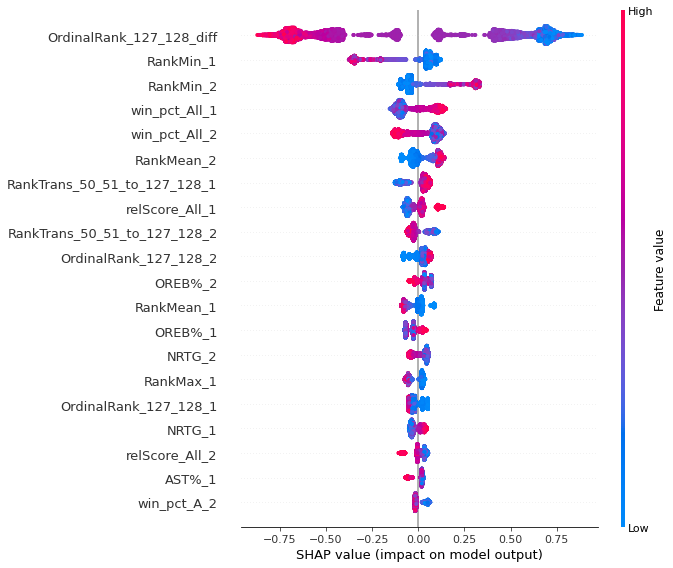

In [47]:
# summarize the effects of all the features
shap.summary_plot(shap_preds[:,:-1], X_test)

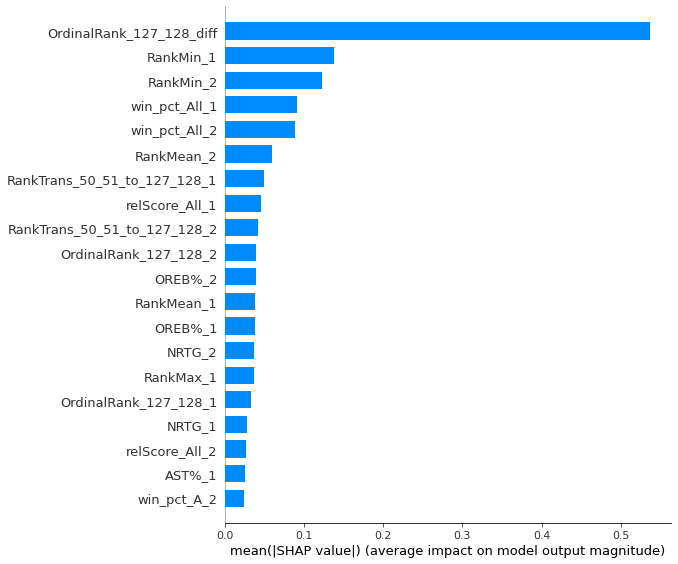

In [48]:
shap.summary_plot(shap_preds[:,:-1], X_test, plot_type="bar")

In [49]:
%%time
shap_interactions = model.predict(test, pred_interactions=True)

CPU times: user 18min 41s, sys: 9.1 s, total: 18min 50s
Wall time: 10min 18s


Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


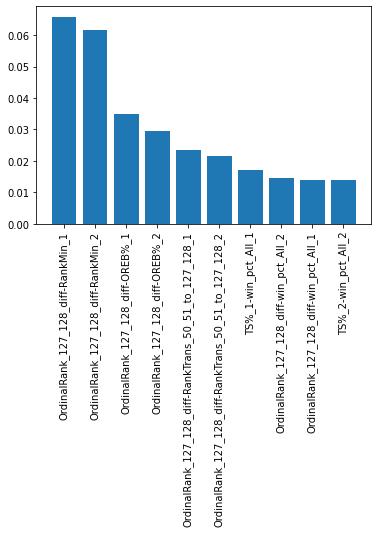

In [50]:
def plot_top_k_interactions(feature_names, shap_interactions, k):
    # Get the mean absolute contribution for each feature interaction
    aggregate_interactions = np.mean(np.abs(shap_interactions[:, :-1, :-1]), axis=0)
    interactions = []
    for i in range(aggregate_interactions.shape[0]):
        for j in range(aggregate_interactions.shape[1]):
            if j < i:
                interactions.append(
                    (feature_names[i] + "-" + feature_names[j], aggregate_interactions[i][j] * 2))
    # sort by magnitude
    interactions.sort(key=lambda x: x[1], reverse=True)
    interaction_features, interaction_values = map(tuple, zip(*interactions))
    plt.bar(interaction_features[:k], interaction_values[:k])
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
    
plot_top_k_interactions(X_test.columns, shap_interactions, 10)

In [51]:
X_test

,win_pct_A_1,win_pct_N_1,win_pct_H_1,win_pct_All_1,win_pct_A_2,win_pct_N_2,win_pct_H_2,win_pct_All_2,Score_A_1,relScore_A_1,...,RankTrans_15_16_to_127_128_1,OrdinalRank_127_128_2,maxRank_127_128_2,RankMax_2,RankMin_2,RankStd_2,RankMean_2,RankTrans_50_51_to_127_128_2,RankTrans_15_16_to_127_128_2,OrdinalRank_127_128_diff
0,0.705882,-1.0,0.800000,0.750000,0.727273,1.000000,1.000000,0.911765,63.000000,4.000000,...,-0.079772,0.002849,351,8,1,1.896204,4.294118,-0.014245,-0.008547,0.415954
1,0.705882,-1.0,0.800000,0.750000,0.583333,0.666667,0.894737,0.764706,63.000000,4.000000,...,-0.079772,0.085470,351,40,21,6.123124,29.352941,0.002849,-0.028490,0.333333
2,0.705882,-1.0,0.800000,0.750000,0.545455,0.500000,0.882353,0.718750,63.000000,4.000000,...,-0.079772,0.051282,351,76,14,19.290161,38.117647,-0.068376,-0.165242,0.367521
3,0.705882,-1.0,0.800000,0.750000,0.466667,1.000000,0.846154,0.677419,63.000000,4.000000,...,-0.079772,0.384615,351,191,116,23.853567,148.352941,0.017094,0.014245,0.034188
4,0.705882,-1.0,0.800000,0.750000,0.615385,0.666667,0.916667,0.741935,63.000000,4.000000,...,-0.079772,0.105413,351,91,37,16.124059,65.117647,-0.059829,-0.076923,0.313390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22775,0.785714,1.0,0.923077,0.866667,0.636364,0.571429,0.937500,0.764706,76.642857,10.571429,...,-0.135977,0.130312,353,78,27,11.475037,45.500000,-0.014164,-0.016997,-0.073654
22776,0.615385,1.0,0.846154,0.750000,0.636364,0.571429,0.937500,0.764706,78.153846,2.769231,...,-0.036827,0.130312,353,78,27,11.475037,45.500000,-0.014164,-0.016997,0.138810
22777,0.785714,1.0,0.923077,0.866667,0.615385,0.600000,0.800000,0.696970,76.642857,10.571429,...,-0.135977,0.045326,353,28,15,3.988955,20.500000,-0.002833,-0.033994,0.011331
22778,0.615385,1.0,0.846154,0.750000,0.615385,0.600000,0.800000,0.696970,78.153846,2.769231,...,-0.036827,0.045326,353,28,15,3.988955,20.500000,-0.002833,-0.033994,0.223796


In [52]:
test = pd.read_csv(DIR_PATH+'/test.csv')
MSampleSubmission = pd.read_csv(DIR_PATH+'/MSampleSubmissionStage1.csv')

In [53]:
test_preds.shape

(22780,)

In [54]:
idx = test_preds.shape[0] //2
test_preds[idx:] = 1 - test_preds[idx:]

pred = pd.concat([test.ID, pd.Series(test_preds)], axis=1).groupby('ID')[0]\
        .mean().reset_index().rename(columns={0:'Pred'})
sub = MSampleSubmission.drop(['Pred'],axis=1).merge(pred, on='ID')
sub.to_csv('submission_xgb.csv', index=False)
sub.head()

,ID,Pred
0,2015_1107_1112,0.096498
1,2015_1107_1116,0.171011
2,2015_1107_1124,0.187930
3,2015_1107_1125,0.310210
4,2015_1107_1129,0.243118


In [55]:
sub

,ID,Pred
0,2015_1107_1112,0.096498
1,2015_1107_1116,0.171011
2,2015_1107_1124,0.187930
3,2015_1107_1125,0.310210
4,2015_1107_1129,0.243118
...,...,...
11385,2019_1449_1459,0.333944
11386,2019_1449_1463,0.733244
11387,2019_1458_1459,0.508079
11388,2019_1458_1463,0.777205
